In [1]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

In [16]:
import TN_utils
reload(TN_utils)

<module 'TN_utils' from 'TN_utils.py'>

In [17]:
feature_vec, GT_vec, mask_vec = TN_utils.load_neuron()

feature_vec.shape (262144, 60, 2)
GT_vec.shape (262144, 2)
mask_vec.shape (262144,)


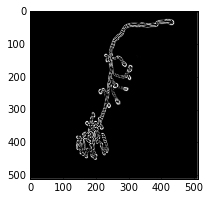

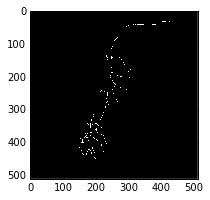

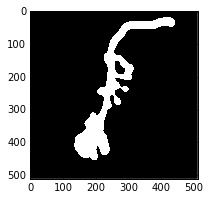

In [18]:
# V test load_toytreefeature_mat
img_shape = (512, 512)
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(feature_vec, axis=2)[:, 12].reshape(img_shape))

plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(GT_vec, axis=1).reshape(img_shape)) 

plt.figure(figsize=(3, 3))
plt.imshow(mask_vec.reshape(img_shape))

In [19]:
m_feature_vec = feature_vec[mask_vec]
m_GT_vec = GT_vec[mask_vec]
print m_feature_vec.shape, m_GT_vec.shape

(25553, 60, 2) (25553, 2)


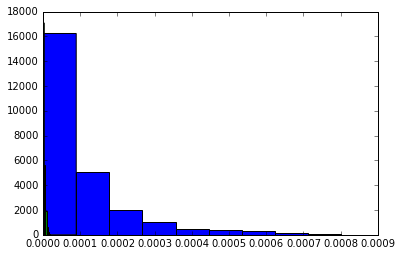

In [21]:
# V 正規化されてない
gomi = plt.hist(np.linalg.norm(m_feature_vec, axis=2)[:, 54])
gomi = plt.hist(np.linalg.norm(m_feature_vec, axis=2)[:, 58])

In [24]:
normed_m_feature_vec, norm_coef = TN_utils.normalize_feature_vec(m_feature_vec)

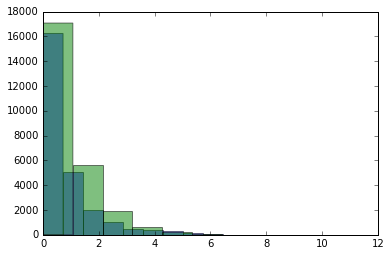

In [25]:
# V まあまあされてる
gomi = plt.hist(np.linalg.norm(normed_m_feature_vec, axis=2)[:, 54], alpha=0.5)
gomi = plt.hist(np.linalg.norm(normed_m_feature_vec, axis=2)[:, 58], alpha=0.5)

In [26]:
import TNN
reload(TNN)

Couldn't import dot_parser, loading of dot files will not be possible.


<module 'TNN' from 'TNN.pyc'>

In [101]:
n_hidden = 100
# test myself
result = TNN.ab(normed_m_feature_vec, m_GT_vec,
                normed_m_feature_vec, m_GT_vec,
                n_hidden=n_hidden, h_activation="ReLU", out_activation="ReLU") 

In [102]:
f_train, f_training_error, f_test_error, f_output, s_input, s_target, param2_list, a_list, b_list, bias_list = result

In [103]:
permu_index = np.random.permutation(range(normed_m_feature_vec.shape[0]))
pnm_feature_vec = normed_m_feature_vec[permu_index]
pm_GT_vec = m_GT_vec[permu_index]

In [104]:
pnm_feature_vec.shape

(25553, 60, 2)

In [105]:
s_input.set_value(pnm_feature_vec)
s_target.set_value(pm_GT_vec)

In [106]:
n_tensor = 60
param2_list[0].set_value(0.01*np.random.normal(size=(n_hidden, )))
param2_list[1].set_value(0.01*np.random.normal(size=(n_hidden, )))
param2_list[2].set_value(0.)
for i in range(n_hidden):
    a_list[i].set_value(0.01*np.random.normal(size=(n_tensor, )))
    b_list[i].set_value(0.01*np.random.normal(size=(n_tensor, )))
    bias_list[i].set_value(0.)

In [107]:
lr = 1.0
reg2 = 0.
batch_size = 1000
n_batchs = s_input.get_value(borrow=True).shape[0] // batch_size

n_epochs = 1000
interval = 100
cost_array = np.zeros((n_epochs // interval,))

In [108]:
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        f_train(i_batch, lr, reg2, batch_size)

    if i_epoch % interval == 0:
        cost = f_training_error()[0]
        cost_array[i_epoch // interval] = cost
        print i_epoch, cost

0 0.0257101189655
100 0.0223009862305
200 0.0211128154445
300 0.020528020825
400 0.0202235029982
500 0.0200632445041
600 0.0199870071068
700 0.0199598565912
800 0.0199616383012
900 0.0199825810041


In [109]:
# V
plt.plot(cost_array)

In [110]:

gt2_vec = f_output(feature_vec/norm_coef[:, np.newaxis])[0]
gt1_img = TN_utils.convert_gt2vec_to_gt1img(gt2_vec, img_shape)
sio.savemat("../tmp/gt1.mat", {"v_train": gt1_img})

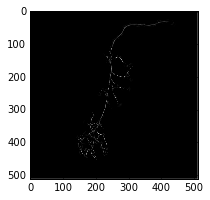

In [112]:
# V
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(gt1_img, axis=0).T)

In [113]:
with open("../results/neuron/error_nh100bs1000.npy", "w") as f:
    np.save(f, cost_array)
sio.savemat("../results/neuron/gt1_nh100bs1000.mat", {"v_train": gt1_img})